In [116]:
import os
import numpy as np
import collections
import pickle
import argparse
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='./')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
#parser.add_argument('--num_units', default=128*2*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=30)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()

In [95]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

In [96]:
class TextLoader():

    def __init__(self, data_dir, batch_size=64, seq_length=50, encoding='utf-8'):
        self.data_dir = data_dir
        self.encoding = encoding
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.input_file = os.path.join(data_dir, 'tinyshakespeare.txt')
        self.vocab_file = os.path.join(data_dir, 'vocab.pkl')
        # Numeric file of characters translated to indices.
        self.tensor_file = os.path.join(data_dir, 'data.npy')
        
        if not (os.path.exists(self.vocab_file) and os.path.exists(self.tensor_file)):
            print('it seems we havent processed the text data yet: reading the shakespear')
            self.preprocess(self.input_file, self.vocab_file, self.tensor_file)
        else:
            print('there are preprocessed data - lets load it')
            self.load_preprocessed(self.vocab_file, self.tensor_file)

        self.create_batches()
        self.reset_batch_pointer()

    # Create numeric file.
    def preprocess(self, input_file=None, vocab_file=None, tensor_file=None, saveit=True):
        if input_file is not None:
            self.input_file = input_file
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.input_file, 'r') as f:
            data = f.read()
        #data = data.lower()
        self.total_length = len(data)
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))

        if saveit:
            with open(self.vocab_file, 'wb') as f:  # saving dictionary so we don't compute it again
                pickle.dump(self.chars, f)
            self.tensor = np.array(list(map(self.vocab_to_idx.get, data)))
            np.save(self.tensor_file, self.tensor)  # saving the numerified data
    # Load numeric file create dictionaries for char2idx and back
    def load_preprocessed(self, vocab_file=None, tensor_file=None):
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.vocab_file, 'rb') as f:
            self.chars = pickle.load(f)

        # attributes
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(self.vocab_size)))
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))
            
    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):

        
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        if self.num_batches == 0:
            assert False, 'Not enough data. Make seq_length and/or batch_size smaller'

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]  # so we get an even divide
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        # ydata is one step ahead of x and last item is first item of x 
        # to get sequences of same length    
        ydata[:-1] = xdata[1:] 
        ydata[-1] = xdata[0]

        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
        
        self.train_num_batches=np.int32(self.num_batches*.8)
        self.test_num_batches=self.num_batches-self.train_num_batches
        self.train_x_batches=self.x_batches[0:self.train_num_batches]
        self.train_y_batches=self.y_batches[0:self.train_num_batches]
        self.test_x_batches=self.x_batches[self.train_num_batches:]
        self.test_y_batches=self.y_batches[self.train_num_batches:]

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch_train(self):
        x, y = self.train_x_batches[self.pointer], self.train_y_batches[self.pointer]
        self.pointer += 1
        return x,y
    
    def next_batch_test(self):
        x, y = self.test_x_batches[self.pointer], self.test_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

In [123]:
loader = TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)
args.num_chars = loader.vocab_size
#print(loader.vocab_size)
print('num chars',args.num_chars)
print('num batches',loader.num_batches)

there are preprocessed data - lets load it
num chars 65
num batches 232


In [98]:
class MyBasicRNNCell(tf.contrib.rnn.BasicRNNCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self._kernel = self.add_variable(name="kernel_hidden", shape=[input_depth + self._num_units, self._num_units])
        self._bias = self.add_variable(name="bias_hidden", shape=[self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        
        output = tf.tanh(tf.matmul(tf.concat([inputs, state], 1), self._kernel) + self._bias)

        return output, output

In [99]:
class MyBasicRNNCell_layer2(tf.contrib.rnn.BasicRNNCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self._kernel = self.add_variable(name="kernel_hidden", shape=[input_depth + self._num_units, 2*self._num_units])
        self._bias = self.add_variable(name="bias_hidden", shape=[2*self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """ RNN with two different layers: draw a random number p; 
            output = tanh(p*weight1) + tanh((1-p)*weight2)"""
        one = tf.constant(1, dtype=tf.int32)
        
        weights = tf.matmul(tf.concat([inputs, state], axis=1), self._kernel) + self._bias
        
        weight1,weight2 = tf.split(
            value=weights, num_or_size_splits=2, axis=one)
        
        rand = tf.random_uniform([1],minval=0,maxval=1,dtype=weight1.dtype, seed = 12345)
        
        output = tf.tanh(rand*weight2)+tf.tanh((1-rand)*weight1)
        
        
        return output, output

In [100]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 4 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[4 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        input_gate_weights, input_weights, forget_gate_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [101]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell_cp_gates(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 4 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[4 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        input_gate_weights, input_weights, forget_gate_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        #input_gate = tf.sigmoid(input_gate_weights)
        input_gate = 1-forget_gate
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [102]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell_GS_var(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + 2*self._num_units, 4 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[4 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h, c], axis=1), self._kernel) + self._bias

        input_gate_weights, input_weights, forget_gate_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [103]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell_wo_outputgate(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 4 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[4 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        input_gate_weights, input_weights, forget_gate_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        #processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = output_gate
        
        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [104]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell_GS(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + 2*self._num_units, 2 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[2 * self._num_units], initializer=tf.zeros_initializer())

        self._kernel2 = self.add_variable(name="kernel2", shape=[input_depth, self._num_units])
        self._bias2 = self.add_variable(name="bias2", shape=[self._num_units], initializer=tf.zeros_initializer())

        self._kernel3 = self.add_variable(name="kernel3", shape=[input_depth + 2*self._num_units, self._num_units])
        self._bias3 = self.add_variable(name="bias3", shape=[self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h,c], axis=1), self._kernel) + self._bias

        forget_gate_weights, input_gate_weights= tf.split(
            value=gate_inputs, num_or_size_splits=2, axis=one)

        #, forget_gate_weights, output_gate_weights 
        
        
        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.matmul(inputs,self._kernel2) + self._bias2       
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        
        output_gate_weights = tf.matmul(tf.concat([inputs, h,new_c], axis=1), self._kernel3) + self._bias3
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [105]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell_GRU(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 2 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[2 * self._num_units], initializer=tf.zeros_initializer())

        self._kernel2 = self.add_variable(name="kernel2", shape=[input_depth + self._num_units, self._num_units])
        self._bias2 = self.add_variable(name="bias2", shape=[self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state
        c = h
        
        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        z_weights, r_weights = tf.split(value=gate_inputs, num_or_size_splits=2, axis=one)
        z_gate = tf.sigmoid(z_weights)
        r_gate = tf.sigmoid(r_weights)
        
        h_tear = tf.tanh(tf.matmul(tf.concat([inputs, r_gate*c], axis=1), self._kernel2) + self._bias2)
        
        
        new_h = (1-z_gate) * h + z_gate*h_tear
        new_c = new_h
        
        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [106]:
def network(myLSTMCell,inputs,targets):

    with tf.variable_scope('embedding_matrix'):
        embedding = tf.get_variable('embedding', [args.num_chars, args.num_units])
        embedded_inputs = tf.nn.embedding_lookup(embedding, inputs)
        inputs_list = tf.unstack(embedded_inputs, axis=1)  # shape: a list of [batch_size, num_units] length num_steps

    with tf.variable_scope('LSTMCell') as myscope:
        cell = myLSTMCell(args.num_units)
        init_state = cell.zero_state(args.batch_size, tf.float32)
        state = init_state
        outputs = []

        for time_, input in enumerate(inputs_list):
            if time_ > 0:
                myscope.reuse_variables()
           
            output, state = cell(input, state)
            outputs.append(output)
    # All hidden outputs for each batch and every step in the batch are reshaped
    # as one long matrix to be transformed to logits and compared to targets.
        output_reshaped = tf.reshape(tf.concat(outputs, 1), [-1, args.num_units])

        final_state = state

    with tf.variable_scope('regression'):
        W = tf.get_variable('W', [args.num_units, args.num_chars])
        b = tf.get_variable('b', [args.num_chars], initializer=tf.constant_initializer(0.0))
        logits = tf.matmul(output_reshaped, W) + b
        prob = tf.nn.softmax(logits)

    with tf.variable_scope('cost'):
        targets_straightened = tf.reshape(targets, [-1])
        crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                    labels=targets_straightened)
        loss = tf.reduce_mean(crossentropy)
        cost = loss/args.batch_size/args.num_steps

    with tf.variable_scope('optimizer'):
        train_step = tf.train.AdamOptimizer(args.lr).minimize(loss)

    with tf.variable_scope('saver'):
        saver = tf.train.Saver()
    return init_state, train_step, loss, final_state, saver, prob

In [107]:
def trainer(myCell,num_batches=None):
    
    start_time = time.time()
    tf.reset_default_graph()
    # Define the placeholders
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    # Create the network
    init_state, train_step, loss, final_state, saver, prob=network(myCell,inputs,targets)
    print('train_num_batches',loader.train_num_batches)
    
    if (num_batches is None):
        num_batches=loader.train_num_batches

    with tf.Session() as sess:
         
        sess.run(tf.global_variables_initializer())
        # computation graph for training
        training_losses = []

        for epoch in range(args.num_epochs):
            loader.reset_batch_pointer()
            state_ = sess.run(init_state)
            training_loss = 0

            for batch in range(num_batches):

                x, y = loader.next_batch_train()

                feed_dict = dict()
                feed_dict[inputs] = x
                feed_dict[targets] = y
                
                if ('RNN' in myCell.__name__):
                    feed_dict[init_state] = state_
                else:
                    feed_dict[init_state.c] = state_.c
                    feed_dict[init_state.h] = state_.h

                train_loss_, state_, _ = sess.run([loss, final_state, train_step], feed_dict=feed_dict)
                training_loss += train_loss_
            training_loss=training_loss/num_batches
            print('epoch:', epoch, 'loss:',  training_loss)
            training_losses.append(training_loss)
        saver.save(sess, os.path.join(args.save_dir, 'saved_model'))
    
    end_time = time.time()
    
    timer(start_time, end_time)
    return(training_losses)

In [38]:
args.batch_size

1

In [14]:
re_lstm_basic = trainer(MyBasicLSTMCell)

train_num_batches 185
epoch: 0 loss: 2.3512845264898763
epoch: 1 loss: 1.79413751395973
epoch: 2 loss: 1.6284469804248294
epoch: 3 loss: 1.5361737489700318
epoch: 4 loss: 1.4740768799910675
epoch: 5 loss: 1.4320809776718553
epoch: 6 loss: 1.399008989978481
epoch: 7 loss: 1.3731264997173
epoch: 8 loss: 1.3506505489349365
epoch: 9 loss: 1.3317207349313271
epoch: 10 loss: 1.3155785425289257
epoch: 11 loss: 1.3017396102080474
epoch: 12 loss: 1.2906548925348231
epoch: 13 loss: 1.2782362216227763
epoch: 14 loss: 1.2672040082312919
epoch: 15 loss: 1.257996859421601
epoch: 16 loss: 1.2500169270747417
epoch: 17 loss: 1.2410382876525055
epoch: 18 loss: 1.232925194018596
epoch: 19 loss: 1.227118014644932
epoch: 20 loss: 1.2206680471832687
epoch: 21 loss: 1.2148376941680907
epoch: 22 loss: 1.2107924835101977
epoch: 23 loss: 1.2043923216897088
epoch: 24 loss: 1.1998636065302668
epoch: 25 loss: 1.1968133829735421
epoch: 26 loss: 1.1937202073432305
epoch: 27 loss: 1.188500223288665
epoch: 28 loss: 1.

In [33]:
re_rnn_basic = trainer(MyBasicRNNCell)

train_num_batches 185
epoch: 0 loss: 2.2818055597511497
epoch: 1 loss: 1.8383384852795988
epoch: 2 loss: 1.6897879845387227
epoch: 3 loss: 1.6083508742822183
epoch: 4 loss: 1.5571155741408065
epoch: 5 loss: 1.5210590182123958
epoch: 6 loss: 1.4940589685697814
epoch: 7 loss: 1.4730424674781593
epoch: 8 loss: 1.4561327470315468
epoch: 9 loss: 1.4421495405403344
epoch: 10 loss: 1.4304097974622572
epoch: 11 loss: 1.4205671742155745
epoch: 12 loss: 1.4117792123072856
epoch: 13 loss: 1.4037732723596934
epoch: 14 loss: 1.396948775085243
epoch: 15 loss: 1.3912428868783486
epoch: 16 loss: 1.3862537145614624
epoch: 17 loss: 1.381768251754142
epoch: 18 loss: 1.3775134099496378
epoch: 19 loss: 1.373505989280907
epoch: 20 loss: 1.3695869316925873
epoch: 21 loss: 1.3661656328149745
epoch: 22 loss: 1.363321708988499
epoch: 23 loss: 1.3609219911936168
epoch: 24 loss: 1.3586723469399118
epoch: 25 loss: 1.3567053562886007
epoch: 26 loss: 1.3552206058759948
epoch: 27 loss: 1.3530423963392102
epoch: 28 lo

In [89]:
def Synthesize(MyCell,init_string="None"):
    tf.reset_default_graph()
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        # Run rnn on initialization data to get final hidden state before simulation
        state_ = sess.run(init_state)
        for i in range(forecast_data.shape[0]):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[i].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            # Get new hidden state and prediction probabilities
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

            predicted_prob = predicted_prob.ravel()
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]


            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

In [19]:
def Tester(MyCell, num_batches=None):
    tf.reset_default_graph()
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        loader.reset_batch_pointer()
        
         # Get test error loss
        test_loss = 0
        print('num_batches',num_batches)

        for batch in range(num_batches):

            x, y = loader.next_batch_test()

            feed_dict = dict()
            feed_dict[inputs] = x
            feed_dict[targets] = y

            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h

            test_loss_, state_= sess.run([loss, final_state], feed_dict=feed_dict)
            test_loss += test_loss_
        test_loss=test_loss/num_batches
        print('test loss:',  test_loss)


    
    return(test_loss)

In [17]:
Tester(MyBasicLSTMCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4114972708073068


1.4114972708073068

In [18]:
Synthesize(MyBasicLSTMCell,"What is the meaning of life")

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifen
As an adite to the presence.

BUCKINGHAM:
Madam, they do that have send you that,
Being, though al


# (a) play with the architecture

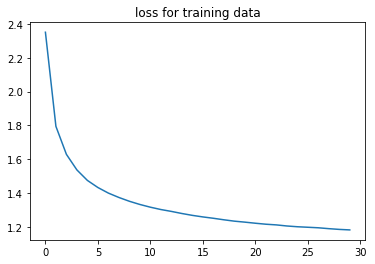

In [21]:
epcs = [i for i in range(len(re_lstm_basic))]
plt.plot(epcs,re_lstm_basic)
plt.title("loss for training data")
plt.show()


In [29]:
Synthesize(MyBasicLSTMCell,"Farewell.")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11 25]
INFO:tensorflow:Restoring parameters from saved_model
Farewell.

MENENIUS:
Not all, to bear, he seek'd i' thy state:
The prisoner of the marker-naturned wife;
Whil


In [30]:
Synthesize(MyBasicLSTMCell,"And keep your honours safe!")

there are preprocessed data - lets load it
[26  8 12  0 28  1  1 23  0 15  3 13  7  0  5  3  8  3 13  7  6  0  6  4
 18  1 46]
INFO:tensorflow:Restoring parameters from saved_model
And keep your honours safe!
Lue and there thou hast not worldly heaven,
Wherein thy huma'st that we swear'd;' 'I'll take
you al


In [31]:
Synthesize(MyBasicLSTMCell,"Look, sir.")

there are preprocessed data - lets load it
[36  3  3 28 16  0  6  9  7 25]
INFO:tensorflow:Restoring parameters from saved_model
Look, sir.

BIANCA:
Beheld him that they be a constitue.

ANGELO:
And with thee, my lord or the letters to hol


In [32]:
Synthesize(MyBasicLSTMCell,"Make good this ostentation, and you shall Divide in all with us.")

there are preprocessed data - lets load it
[42  4 28  1  0 20  3  3 12  0  2  5  9  6  0  3  6  2  1  8  2  4  2  9
  3  8 16  0  4  8 12  0 15  3 13  0  6  5  4 11 11  0 47  9 27  9 12  1
  0  9  8  0  4 11 11  0 17  9  2  5  0 13  6 25]
INFO:tensorflow:Restoring parameters from saved_model
Make good this ostentation, and you shall Divide in all with us.

QUEEN MARGARET:
No more are shoning, be mocker.

PAULINA:
I'll stay as I die, who is the morn outs


In [28]:
Tester(MyBasicLSTMCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4114972708073068


1.4114972708073068

## Comment:
The results do not seem to perform very well. 

# (b) Compare with RNN

In [124]:
re_rnn_basic = trainer(MyBasicRNNCell)

train_num_batches 185
epoch: 0 loss: 2.278072653590022
epoch: 1 loss: 1.8336338146312816
epoch: 2 loss: 1.686809637095477
epoch: 3 loss: 1.6048998574952822
epoch: 4 loss: 1.5534927690351332
epoch: 5 loss: 1.5175468992542576
epoch: 6 loss: 1.490863183382395
epoch: 7 loss: 1.470065796697462
epoch: 8 loss: 1.4533231818998182
epoch: 9 loss: 1.4395658673466862
epoch: 10 loss: 1.427987441501102
epoch: 11 loss: 1.4180384300850533
epoch: 12 loss: 1.4094094727490398
epoch: 13 loss: 1.4018475345663122
epoch: 14 loss: 1.395225325146237
epoch: 15 loss: 1.3894909530072599
epoch: 16 loss: 1.384377310082719
epoch: 17 loss: 1.3799945618655232
epoch: 18 loss: 1.3761914362778536
epoch: 19 loss: 1.3724097387210743
epoch: 20 loss: 1.368999376168122
epoch: 21 loss: 1.3666021347045898
epoch: 22 loss: 1.3643000132328755
epoch: 23 loss: 1.3605506465241717
epoch: 24 loss: 1.3568198912852518
epoch: 25 loss: 1.3539022484341183
epoch: 26 loss: 1.3515175497209704
epoch: 27 loss: 1.3498986650157618
epoch: 28 loss: 

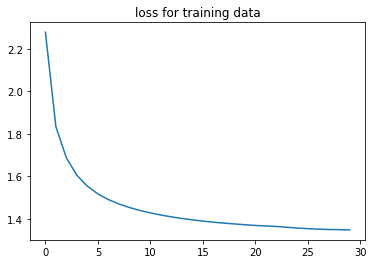

In [126]:
epcs = [i for i in range(len(re_rnn_basic))]
plt.plot(epcs,re_rnn_basic)
plt.title("loss for training data")
plt.show()


In [128]:
Tester(MyBasicRNNCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4653091430664062


1.4653091430664062

In [127]:
Synthesize(MyBasicRNNCell,"Farewell.")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11 25]
INFO:tensorflow:Restoring parameters from saved_model
Farewell.
Ahoman's like me;
And,
So should to the brave and by his father by the commands of the word.

ARIEL


In [37]:
Synthesize(MyBasicRNNCell,"And keep your honours safe!")

there are preprocessed data - lets load it
[26  8 12  0 28  1  1 23  0 15  3 13  7  0  5  3  8  3 13  7  6  0  6  4
 18  1 46]
INFO:tensorflow:Restoring parameters from saved_model
And keep your honours safe!

ANGELO:
A bays,
And by my brother,
Make all this is to see that the chieful and bride them about t


In [38]:
Synthesize(MyBasicRNNCell,"Look, sir.")

there are preprocessed data - lets load it
[36  3  3 28 16  0  6  9  7 25]
INFO:tensorflow:Restoring parameters from saved_model
Look, sir.

AUTOLYCUS:
And see the word.

BRUTUS:
In all thy morching by him.

Clord:
What would not as her fo


In [39]:
Synthesize(MyBasicRNNCell,"Make good this ostentation, and you shall Divide in all with us.")

there are preprocessed data - lets load it
[42  4 28  1  0 20  3  3 12  0  2  5  9  6  0  3  6  2  1  8  2  4  2  9
  3  8 16  0  4  8 12  0 15  3 13  0  6  5  4 11 11  0 47  9 27  9 12  1
  0  9  8  0  4 11 11  0 17  9  2  5  0 13  6 25]
INFO:tensorflow:Restoring parameters from saved_model
Make good this ostentation, and you shall Divide in all with us.

DUKE VINCENTIO:
Why, when thy tone, brother of the pray, and thence ourselves.--warring to be sent


## (C)

## alternative one: enhanced RNN
I change the default of num_units to be 2 times the original.<br>
When dimension of dim(h) >> dim(x), we have 4 times the number of paramters

In [108]:
re_rnn_same_para_as_LSTM = trainer(MyBasicRNNCell)

train_num_batches 185
epoch: 0 loss: 2.211919324462478
epoch: 1 loss: 1.7509866198977908
epoch: 2 loss: 1.5972390954558913
epoch: 3 loss: 1.5154110064377655
epoch: 4 loss: 1.4637490813796585
epoch: 5 loss: 1.4285416764182013
epoch: 6 loss: 1.400735107628075
epoch: 7 loss: 1.378274722357054
epoch: 8 loss: 1.359726594589852
epoch: 9 loss: 1.345980387765008
epoch: 10 loss: 1.3347510666460605
epoch: 11 loss: 1.3255704125842533
epoch: 12 loss: 1.3183947750040004
epoch: 13 loss: 1.3102646718154083
epoch: 14 loss: 1.3044025904423482
epoch: 15 loss: 1.3016612774616962
epoch: 16 loss: 1.2991381149034242
epoch: 17 loss: 1.2928764001743214
epoch: 18 loss: 1.2883972915443214
epoch: 19 loss: 1.2845338247917795
epoch: 20 loss: 1.2809447662250415
epoch: 21 loss: 1.2774507806107804
epoch: 22 loss: 1.2761928429474703
epoch: 23 loss: 1.2765189138618676
epoch: 24 loss: 1.2766954550871978
epoch: 25 loss: 1.272276925396275
epoch: 26 loss: 1.2711892682152826
epoch: 27 loss: 1.271570290101541
epoch: 28 loss:

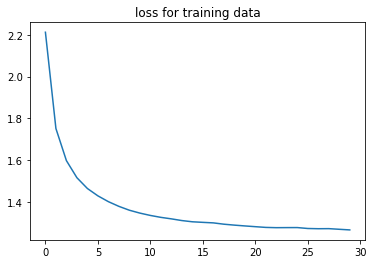

In [111]:
epcs = [i for i in range(len(re_rnn_same_para_as_LSTM))]
plt.plot(epcs,re_rnn_same_para_as_LSTM)
plt.title("loss for training data")
plt.show()

In [110]:
Tester(MyBasicRNNCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4517813718065302


1.4517813718065302

## Analysis: 
with increasing number of paramters, the error rate on training data indeed drops.

## Alternative 2: RNN with two layers

In [112]:
re_rnn_two_layers = trainer(MyBasicRNNCell_layer2)

train_num_batches 185
epoch: 0 loss: 2.4672364054499445
epoch: 1 loss: 2.0464838723878604
epoch: 2 loss: 1.8691121114266884
epoch: 3 loss: 1.7355025104574255
epoch: 4 loss: 1.64565470863033
epoch: 5 loss: 1.5886850846780314
epoch: 6 loss: 1.5472483570511277
epoch: 7 loss: 1.5071861170433662
epoch: 8 loss: 1.4840407416627215
epoch: 9 loss: 1.4645576721913105
epoch: 10 loss: 1.4452389614002126
epoch: 11 loss: 1.4257637288119343
epoch: 12 loss: 1.4035859855445656
epoch: 13 loss: 1.3947516061164238
epoch: 14 loss: 1.3857541019852098
epoch: 15 loss: 1.3742644245560105
epoch: 16 loss: 1.359066654540397
epoch: 17 loss: 1.3502300597525931
epoch: 18 loss: 1.3506952002241805
epoch: 19 loss: 1.3409954721863206
epoch: 20 loss: 1.3319525551151585
epoch: 21 loss: 1.3233729581575135
epoch: 22 loss: 1.3179338751612484
epoch: 23 loss: 1.3198697161030124
epoch: 24 loss: 1.3150296237017658
epoch: 25 loss: 1.3016919219816052
epoch: 26 loss: 1.304314630096023
epoch: 27 loss: 1.301042060594301
epoch: 28 los

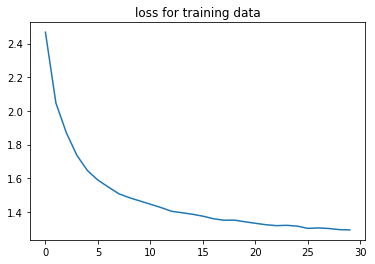

In [114]:
epcs = [i for i in range(len(re_rnn_two_layers))]
plt.plot(epcs,re_rnn_two_layers)
plt.title("loss for training data")
plt.show()


In [120]:
Tester(MyBasicRNNCell_layer2)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4558151402371995


1.4558151402371995

## Alternative 3: Coupled gating

In [79]:
re_lstm_cp_gates = trainer(MyBasicLSTMCell_cp_gates)

train_num_batches 185
epoch: 0 loss: 2.430436626640526
epoch: 1 loss: 1.7901355685414495
epoch: 2 loss: 1.602505157444928
epoch: 3 loss: 1.509585175643096
epoch: 4 loss: 1.4519999839164115
epoch: 5 loss: 1.4138293897783434
epoch: 6 loss: 1.383643710935438
epoch: 7 loss: 1.3596576362042814
epoch: 8 loss: 1.339954027614078
epoch: 9 loss: 1.3235926099725672
epoch: 10 loss: 1.3096334354297534
epoch: 11 loss: 1.2973150820345491
epoch: 12 loss: 1.2858696724917438
epoch: 13 loss: 1.275561615583059
epoch: 14 loss: 1.2664476517084482
epoch: 15 loss: 1.2583503188313665
epoch: 16 loss: 1.2508353884155685
epoch: 17 loss: 1.243690853505521
epoch: 18 loss: 1.2370720302736438
epoch: 19 loss: 1.2310091875694893
epoch: 20 loss: 1.2281230868519963
epoch: 21 loss: 1.2232521720834681
epoch: 22 loss: 1.2218774982400842
epoch: 23 loss: 1.2181442176973498
epoch: 24 loss: 1.21158383794733
epoch: 25 loss: 1.2084172725677491
epoch: 26 loss: 1.2057380180101136
epoch: 27 loss: 1.2027050121410472
epoch: 28 loss: 1

In [82]:
Tester(MyBasicLSTMCell_cp_gates)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4077468349578532


1.4077468349578532

In [121]:
Synthesize(MyBasicLSTMCell_cp_gates,"Farewell.")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11 25]
INFO:tensorflow:Restoring parameters from saved_model


NotFoundError: Key LSTMCell/my_basic_lstm_cell_cp_gates/bias not found in checkpoint
	 [[Node: saver/save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_saver/save/Const_0_0, saver/save/RestoreV2/tensor_names, saver/save/RestoreV2/shape_and_slices)]]

Caused by op 'saver/save/RestoreV2', defined at:
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-121-d0705f03a1e4>", line 1, in <module>
    Synthesize(MyBasicLSTMCell_cp_gates,"Farewell.")
  File "<ipython-input-89-b0d74a6c587c>", line 10, in Synthesize
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)
  File "<ipython-input-106-5c9645b17b99>", line 43, in network
    saver = tf.train.Saver()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key LSTMCell/my_basic_lstm_cell_cp_gates/bias not found in checkpoint
	 [[Node: saver/save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_saver/save/Const_0_0, saver/save/RestoreV2/tensor_names, saver/save/RestoreV2/shape_and_slices)]]


## Analysis 4
Gers_Schmidhuber_variant: Similar to GS,<br>
except that I use the old cell state in the output generation.

In [15]:
re_lstm_gsv = trainer(MyBasicLSTMCell_GS_var)

train_num_batches 185
epoch: 0 loss: 3.363343974706289
epoch: 1 loss: 3.3163019927772317
epoch: 2 loss: 3.315732444299234
epoch: 3 loss: 3.3158376861262964
epoch: 4 loss: 3.3160069298099826
epoch: 5 loss: 3.3159387756038354
epoch: 6 loss: 3.315959697156339
epoch: 7 loss: 3.3155026384302086
epoch: 8 loss: 3.3154809255857725
epoch: 9 loss: 3.315448213267971
epoch: 10 loss: 3.3159282555451264
epoch: 11 loss: 3.3196518395398114
epoch: 12 loss: 3.3397991554157156
epoch: 13 loss: 3.3248990097561397
epoch: 14 loss: 3.318152376123377
epoch: 15 loss: 3.315842967420011
epoch: 16 loss: 3.31541095166593
epoch: 17 loss: 3.31460062748677
epoch: 18 loss: 3.3142789531398464
epoch: 19 loss: 3.314352188883601
epoch: 20 loss: 3.3144172720006995
epoch: 21 loss: 3.3146032178724134
epoch: 22 loss: 3.3137088608097387
epoch: 23 loss: 3.314081706227483
epoch: 24 loss: 3.313422527828732
epoch: 25 loss: 3.3145206064791295
epoch: 26 loss: 3.3148009003819645
epoch: 27 loss: 3.315016305768812
epoch: 28 loss: 3.3144

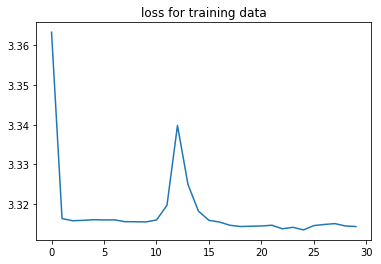

In [16]:
epcs = [i for i in range(len(re_lstm_gsv))]
plt.plot(epcs,re_lstm_gsv)
plt.title("loss for training data")
plt.show()


In [22]:
Synthesize(MyBasicLSTMCell_GS_var,"Farewell.")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11 25]
INFO:tensorflow:Restoring parameters from saved_model
Farewell. h s neenonnoa e th eah  oe aoaa ooe ho a h  eoa eeaeh e  aaeooo   
o  ttt t   

 o o  o ee ttto e e


## Alternative 5: LSTM without outgating


In [55]:
re_lstm_wo_outgate = trainer(MyBasicLSTMCell_without_outputgat)

train_num_batches 185
epoch: 0 loss: 2.511373808577254
epoch: 1 loss: 1.9185032599681133
epoch: 2 loss: 1.7227911723626625
epoch: 3 loss: 1.6110828824945398
epoch: 4 loss: 1.5375597599390392
epoch: 5 loss: 1.4864330994116293
epoch: 6 loss: 1.4469531703639675
epoch: 7 loss: 1.4160834976144738
epoch: 8 loss: 1.3893059021717793
epoch: 9 loss: 1.3695026958310925
epoch: 10 loss: 1.3505120850898125
epoch: 11 loss: 1.3340654959549776
epoch: 12 loss: 1.3195242978431083
epoch: 13 loss: 1.3065423308192072
epoch: 14 loss: 1.29625913774645
epoch: 15 loss: 1.2858429019515578
epoch: 16 loss: 1.276657953133454
epoch: 17 loss: 1.2668228284732717
epoch: 18 loss: 1.2582147250304352
epoch: 19 loss: 1.2505114291165327
epoch: 20 loss: 1.2436416903057614
epoch: 21 loss: 1.2398329921670863
epoch: 22 loss: 1.2333261399655728
epoch: 23 loss: 1.2277124843081912
epoch: 24 loss: 1.2235617051253447
epoch: 25 loss: 1.2173865015442307
epoch: 26 loss: 1.2146573292242515
epoch: 27 loss: 1.2127425967036067
epoch: 28 lo

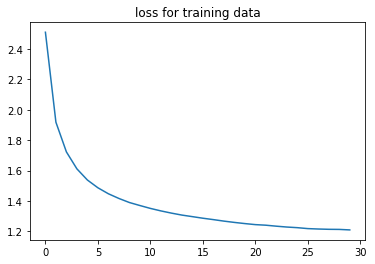

In [57]:
epcs = [i for i in range(len(re_lstm_wo_outgate))]
plt.plot(epcs,re_lstm_wo_outgate)
plt.title("loss for training data")
plt.show()


In [58]:
Synthesize(MyBasicLSTMCell_without_outputgat,"Farewell.")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11 25]
INFO:tensorflow:Restoring parameters from saved_model
Farewell.

ANTIGO:
He's not to the matter, too much brave her tempore of criest;
Frow,--

DUENGEY:
'That's a 


In [59]:
Tester(MyBasicLSTMCell_without_outputgat)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4064168448143817


1.4064168448143817

## Alternative 6: LSTM_GRU

In [62]:
re_lstm_gru = trainer(MyBasicLSTMCell_GRU)

train_num_batches 185
epoch: 0 loss: 2.3532909090454512
epoch: 1 loss: 1.7603168223355268
epoch: 2 loss: 1.5794842720031739
epoch: 3 loss: 1.4894758263149777
epoch: 4 loss: 1.4323072755658948
epoch: 5 loss: 1.3915394783020019
epoch: 6 loss: 1.3605290226034217
epoch: 7 loss: 1.3356301275459497
epoch: 8 loss: 1.3147145599932284
epoch: 9 loss: 1.2973495399629749
epoch: 10 loss: 1.2832167554546048
epoch: 11 loss: 1.2683722818219985
epoch: 12 loss: 1.255678846385028
epoch: 13 loss: 1.2444079263790233
epoch: 14 loss: 1.2350240410985174
epoch: 15 loss: 1.2270012365805136
epoch: 16 loss: 1.2179086665849428
epoch: 17 loss: 1.209876968409564
epoch: 18 loss: 1.2036613174386928
epoch: 19 loss: 1.1979983935485015
epoch: 20 loss: 1.1939614540821797
epoch: 21 loss: 1.1928269863128662
epoch: 22 loss: 1.191805209340276
epoch: 23 loss: 1.1874607820768615
epoch: 24 loss: 1.1849958574449695
epoch: 25 loss: 1.1824677364246265
epoch: 26 loss: 1.179753786164361
epoch: 27 loss: 1.1775933813404393
epoch: 28 lo

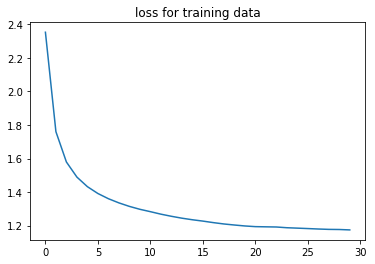

In [63]:
epcs = [i for i in range(len(re_lstm_gru))]
plt.plot(epcs,re_lstm_gru)
plt.title("loss for training data")
plt.show()


In [64]:
Tester(MyBasicLSTMCell_GRU)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4556386293248926


1.4556386293248926

In [ ]:
## seem to be overfitting

In [69]:
re_lstm_gs = trainer(MyBasicLSTMCell_GS)

train_num_batches 185
epoch: 0 loss: 2.772908304833077
epoch: 1 loss: 2.484741784430839
epoch: 2 loss: 2.4722106650068953
epoch: 3 loss: 2.4704143343745053
epoch: 4 loss: 2.468414695842846
epoch: 5 loss: 2.466290939176405
epoch: 6 loss: 2.4652486362972774
epoch: 7 loss: 2.4660537784164016
epoch: 8 loss: 2.4636327202255663
epoch: 9 loss: 2.4623569436975425
epoch: 10 loss: 2.462588102753098
epoch: 11 loss: 2.4651515161668933
epoch: 12 loss: 2.463069286861935
epoch: 13 loss: 2.4629000174032676
epoch: 14 loss: 2.461966625419823
epoch: 15 loss: 2.4614935063027046
epoch: 16 loss: 2.4591001691044987
epoch: 17 loss: 2.4596380581726898
epoch: 18 loss: 2.458849503542926
epoch: 19 loss: 2.458760133949486
epoch: 20 loss: 2.458425145535856
epoch: 21 loss: 2.460179867615571
epoch: 22 loss: 2.459446769147306
epoch: 23 loss: 2.456298485317746
epoch: 24 loss: 2.4558610929025186
epoch: 25 loss: 2.4564284427745924
epoch: 26 loss: 2.4570985665192477
epoch: 27 loss: 2.4574203980935585
epoch: 28 loss: 2.454

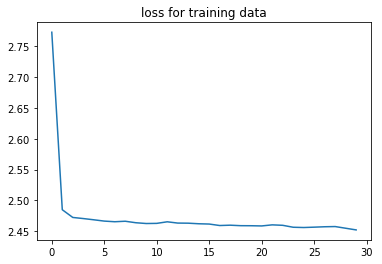

In [71]:
epcs = [i for i in range(len(re_lstm_gs))]
plt.plot(epcs,re_lstm_gs)
plt.title("loss for training data")
plt.show()


In [72]:
Tester(MyBasicLSTMCell_GS)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 2.4673286955407323


2.4673286955407323

In [73]:
Synthesize(MyBasicLSTMCell_GS,"Farewell.")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11 25]
INFO:tensorflow:Restoring parameters from saved_model
Farewell.
They shat whe berded mat pay pratrs tores serthillllllles tithedere teral hond ho averoustorarourer
